<a href="https://colab.research.google.com/github/purpal9/goesFRP_ukmet/blob/main/notebook_get_hms_frp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=2be0e81b4b8e737eb2160ebcf547d912c97be9df55da283fcc49ae8ecf0fbd67
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [2]:
import geopandas
import pytz
from datetime import datetime
import os
import shutil
import wget
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def get_frp_fn_url(dt):
    tt = dt.timetuple()
    month = str(tt.tm_mon).zfill(2)
    day = str(tt.tm_mday).zfill(2)
    yr = str(tt.tm_year)
    fn = 'hms_fire{}{}{}.zip'.format(yr, month, day)
    url = 'https://satepsanone.nesdis.noaa.gov/pub/FIRE/web/HMS/Fire_Points/Shapefile/{}/{}/{}'.format(yr, month, fn)
    return fn, url

In [14]:
def get_frp(dt, frp_dir):
    fn, url = get_frp_fn_url(dt)
    frp_shape_fn = frp_dir + fn
    print(frp_shape_fn)
    if os.path.exists(frp_shape_fn):
        print("{} already exists".format(fn))
    else:
        print('DOWNLOADING frp: {}'.format(fn))
        filename = wget.download(url, out=frp_dir)
        shutil.unpack_archive(filename, frp_dir)
    frp = geopandas.read_file(frp_shape_fn)
    return frp


In [19]:
dt_str = '2023/04/04 14:50'
dt = pytz.utc.localize(datetime.strptime(dt_str, '%Y/%m/%d %H:%M'))
print(dt)
#get_frp(dt, "/home/rey/projects/GOES_FRP/frp_shapefiles/")
frp = get_frp(dt, "./")

## Clean out the -999 FRP values
frp = frp[frp.FRP != -999]

## Set a lat/lon cutoff
frp = frp[frp.Lon <= -105]
frp = frp[frp.Lat <= 48]
frp = frp[frp.Lat >= 30]

2023-04-04 14:50:00+00:00
./hms_fire20230404.zip
hms_fire20230404.zip already exists


frp geodataframe:                Lon        Lat  YearDay  Time  Satellite Method  Ecosystem  \
2332  -119.126750  46.608402  2023094  0917  SUOMI NPP  VIIRS         38   
2333  -119.119090  46.607929  2023094  0917  SUOMI NPP  VIIRS         38   
2347  -120.611320  37.592503  2023094  0917  SUOMI NPP  VIIRS         43   
2348  -120.604910  37.592010  2023094  0917  SUOMI NPP  VIIRS         43   
2393  -119.122940  46.608345  2023094  1003    NOAA 20  VIIRS         38   
...           ...        ...      ...   ...        ...    ...        ...   
44667 -108.295227  30.649420  2023095  0110  GOES-EAST    FDC         40   
44723 -117.190060  41.420158  2023095  0111  GOES-EAST    FDC         52   
44725 -108.295235  30.649422  2023095  0111  GOES-EAST    FDC         40   
44783 -108.295235  30.649422  2023095  0116  GOES-EAST    FDC         40   
44839 -120.018590  46.507580  2023095  0120  GOES-EAST    FDC         52   

          FRP                     geometry  
2332    3.019   POINT (

Text(0, 0.5, 'frequency')

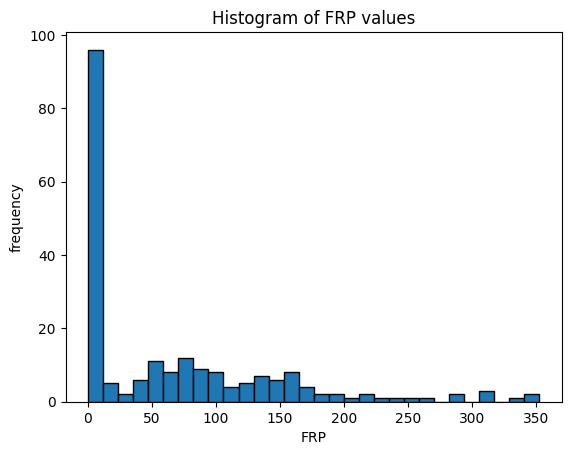

In [20]:
## save frp into variable
print('frp geodataframe: ', frp)
print('frp FRP: ', frp.FRP)

## find quantiles on the variable
for p in np.arange(0,1.1,0.1):
  p_value = frp.FRP.quantile(p)
  print('The ', p, ' percentile is value is: ', p_value)
#frp.FRP.quantile([0.25,0.5,0.75])
print('FRP max: ', frp.FRP.max())
print('FRP min: ', frp.FRP.min())
print('FRP mean: ', frp.FRP.mean())

## plot histogram
plt.hist(frp.FRP, bins=30, edgecolor='black')
plt.title('Histogram of FRP values')
plt.xlabel('FRP')
plt.ylabel('frequency')

Text(0, 0.5, 'frequency')

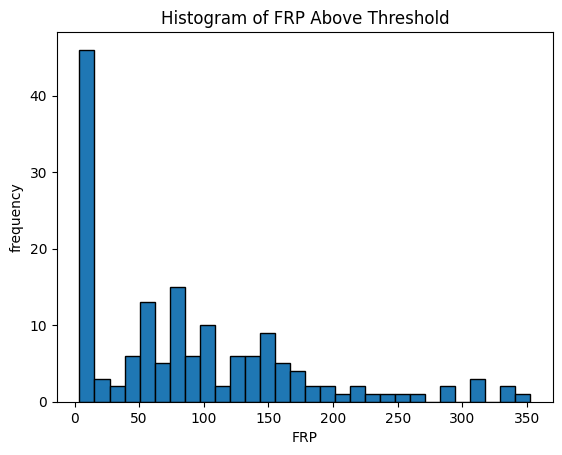

In [21]:
## Drop FRP based on lower [SPECIFY] percentile
quant_thresh = 0.25
frp = frp[frp.FRP >= frp.FRP.quantile(quant_thresh)]

## plot histogram
plt.hist(frp.FRP, bins=30, edgecolor='black')
plt.title('Histogram of FRP Above Threshold')
plt.xlabel('FRP')
plt.ylabel('frequency')